In [1]:
## Import packages
%matplotlib inline
import numpy as np
import scipy.constants as sc
import scipy.sparse as sp
from qutip import *
import matplotlib.pyplot as plt
import math

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/data.py:126: RuntimeWarning: invalid value encountered in multiply
  return self._with_data(self.data * other)


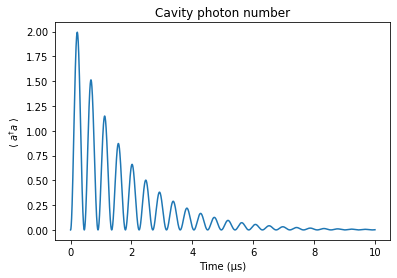

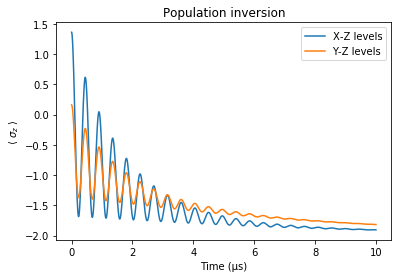

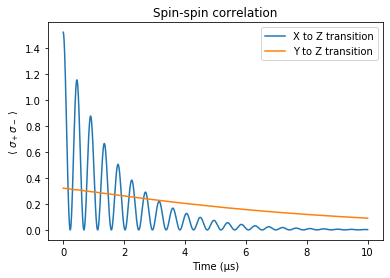

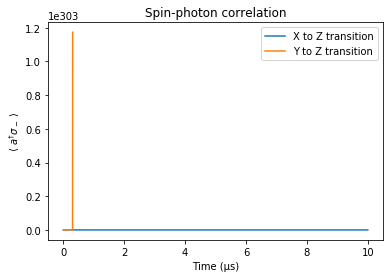

In [318]:
## Dimensional operators
cav_dim = 2 # types of photons there can exist (thermal or participaitn gin excitation)
atm_dim = 3 # energy levels in the atom, 3 for three-level system
I_cav = qeye(cav_dim) # identity matrix matching dimension of radiation field
I_atom = qeye(atm_dim) # identity matrix matching dimension of spin system

## Atomic basis states
one, two, three = basis(3,0), basis(3,1), basis(3,2) ## correponds to X, Y and Z levels

## Atomic raising and lowering operators
sigma13 = tensor((three * one.dag()), I_cav) # lowering from one to three
sigma31 = tensor((one * three.dag()), I_cav) # raising from three to one
sigma23 = tensor((three * two.dag()), I_cav) # lowering from two to three
sigma32 = tensor((two * three.dag()), I_cav) # raising from three to two
sigma12 = tensor((two * one.dag()), I_cav) # lowering from one to two
sigma21 = tensor((one * two.dag()), I_cav) # raising from two to one

## Atomic inversion operators
sigmaz13 = commutator(sigma31, sigma13)
sigmaz23 = commutator(sigma32, sigma23)
sigmaz12 = commutator(sigma21, sigma12)

## Photon operators
adag1 = create(cav_dim)             
a1 = destroy(cav_dim)

adag = tensor(I_atom, create(cav_dim)) # order of arguments is important and is consistant with the spin operators #add .unit()               
a = tensor(I_atom, destroy(cav_dim))

## Physical constants
N = 7e14 #number of three-level systems
wc = 2 * np.pi * 1.45e3 # cavity frequency with vacuum field energy set to zero (zero-point energy) (MHz)
w13 = 2 * np.pi * 1.45e3 # atom transition frequency between levels X & Z (MHz)
w23 = 2 * np.pi * 1.344e3 # atom transition frequency between levels Y & Z (MHz) 1.344 under no magnetic field
w12 = 2 * np.pi * 106.5 # atom transition frequency between levels X & Y (MHz)
g = 2 * np.pi * 0.042e-6 # collective spin-photon couling strength ~ np.sqrt(tls_num)*g, experimetnally it's 1.1 though.
#assume the coupling strength is equal, because the cavity mode should be equally detuned from both transitions. 
#gs = 2 * np.pi * 0.042e-6 # single spin–photon coupling strength (MHz)

Kc = 2 * np.pi * 0.18 # cavity mode decay rate (MHz) # derivation can be found in Agarwal pg.31
Ks = 2 * np.pi * 0.11 # spin dephasing rate (MHz)
gamma_13 = 2 * np.pi * 0.011 # spin-lattice relaxation rate between X and Z
gamma_12 = 2 * np.pi * 0.004 # spin-lattice relaxation rate between X and Y
gamma_23 = 2 * np.pi * 0.022 # spin-lattice relaxation rate between Y and Z

## Initial quantum states
psi_atm = np.sqrt(0.76)*one + np.sqrt(0.16)*two + np.sqrt(0.08)*three
psi_phot = fock(cav_dim, 0)
psi0 = tensor(psi_atm, psi_phot)
rho0 = ket2dm(psi0) # composite density matrix

## The Hamiltonian for a single atom
HA1 = 0.5 * (w13*sigmaz13) #atomic part
HF1 = w13 * (adag*a) #field part
HI1 = np.sqrt(N)*g*(sigma31*a + sigma13*adag) #interaction part in the RWA
H1 = HA1 + HF1 + HI1

HA2 = + 0.5 * (w23*sigmaz23) #atomic part
HF2 = w23 * (adag*a) # field part
HI2 = np.sqrt(N)*g*(sigma32*a + sigma23*adag)  # interaction part in the RWA
H2 = HA2 + HF2 + HI2

H = H1 + H2 #effective Hamiltonian for two transitions

## function computing the Lindblad master equation
def lindblad(p):
    
    #should sumer over all the atoms....
    closed_system = -1j * commutator(H1,p)
    cavity_decay = (Kc/2 * (adag*a*p - 2*a*p*adag + p*adag*a))
    spin_relax13 = (gamma_13/2 * (sigma31*sigma13*p - 2*sigma13*p*sigma31 + p*sigma31*sigma13)) #relaxation rate X to Z
    spin_relax12 = (gamma_12/2 * (sigma21*sigma12*p - 2*sigma12*p*sigma21 + p*sigma21*sigma12)) #relaxation rate X to Y
    spin_relax23 = (gamma_23/2 * (sigma32*sigma23*p - 2*sigma23*p*sigma32 + p*sigma32*sigma23)) #relaxation rate Y to Z
    
    #combine into one equation^(maybe)
    
    return closed_system - cavity_decay - spin_relax13 - spin_relax12 - spin_relax23


## Simulation initialization
step_num = 3000 # number of steps to be used in evolution
tlist = np.linspace(0, 10, step_num) # time points and duration of evolution
step_size = tlist[1] - tlist[0]
step_index = 0

## Density matrix initialiaztion
rho = np.array([np.array(rho0)]) # converting rho0 to numpy array compatible with numpy list
rho_list = rho # initial density matrix is the first entry of the list

## Observable initialization
n_phot_list = ((adag * a).ptrace(1) * rho0.ptrace(1)).tr() # number of photons in light field
inversion13_list = (sigmaz13.ptrace(0) * rho0.ptrace(0)).tr() # population inversion operator 
inversion23_list = (sigmaz23.ptrace(0) * rho0.ptrace(0)).tr() # population inversion operator
spin_spin13_list = ((sigma31 * sigma13).ptrace(0) * rho0.ptrace(0)).tr() # spin-spin correlation
spin_spin23_list = ((sigma32 * sigma23).ptrace(0) * rho0.ptrace(0)).tr() # spin-spin correlation
spin13_phot_list = ((adag * sigma13) * rho0).tr() # spin-photon correlation
spin23_phot_list = ((adag * sigma23) * rho0).tr() # spin-photon correlation


## RK4 method realized using a for loop
for step_index in range(step_num-1):

    rho_old = Qobj(rho_list[step_index], dims=[[3,2],[3,2]]) # takes density matrix calculated from previous iteration
                                                             # and converts to a Qobj
    ## equations needed for RK4 method
    k1 = step_size * lindblad(rho_old)
    k2 = step_size * lindblad(rho_old + 0.5*k1)
    k3 = step_size * lindblad(rho_old + 0.5*k2)
    k4 = step_size * lindblad(rho_old + k3)
    
    rho_new = rho_old + 1/6*k1 + 1/3*(k2+k3) + 1/6*k4 # calculation of density matrix at n+1 step
    
    ## calculating observables at n+1 step using density matrix found above and adding them to list 
    n_phot_new = ((adag * a).ptrace(1) * rho_new.ptrace(1)).tr()
    n_phot_list = np.append(n_phot_list, n_phot_new)
    
    inversion13_new = (sigmaz13.ptrace(0) * rho_new.ptrace(0)).tr()
    inversion13_list = np.append(inversion13_list, inversion13_new)
    
    inversion23_new = (sigmaz23.ptrace(0) * rho_new.ptrace(0)).tr()
    inversion23_list = np.append(inversion23_list, inversion23_new)
    
    spin_spin13_new = ((sigma31 * sigma13).ptrace(0) * rho_new.ptrace(0)).tr()
    spin_spin13_list = np.append(spin_spin13_list, spin_spin13_new)
    
    spin_spin23_new = ((sigma32 * sigma23).ptrace(0) * rho_new.ptrace(0)).tr()
    spin_spin23_list = np.append(spin_spin23_list, spin_spin23_new)
    
    spin13_phot_new = ((adag * sigma13)* rho_new).tr().imag
    spin13_phot_list = np.append(spin13_phot_list, spin13_phot_new)
    
    spin23_phot_new = ((adag * sigma23)* rho_new).tr().imag
    spin23_phot_list = np.append(spin23_phot_list, spin23_phot_new)

    rho_new = np.array([np.array(rho_new)]) # converting the density matrix at the n+1 step to an numpy array
    rho_list = np.append(rho_list, rho_new, axis=0) # save n+1 density matrix for next interation by adding to list


## Visualization
plt.figure(1)
plt.plot(tlist, n_phot_list)
plt.title('Cavity photon number')
plt.ylabel('⟨ ${a^\dag}a$ ⟩')
plt.xlabel('Time (μs)')

plt.figure(2)
plt.plot(tlist, inversion13_list)
plt.plot(tlist, inversion23_list)
plt.legend(("X-Z levels", "Y-Z levels"))
plt.title('Population inversion')
plt.ylabel('⟨ ${σ_z}$ ⟩')
plt.xlabel('Time (μs)')

plt.figure(3)
plt.plot(tlist, spin_spin13_list)
plt.plot(tlist, spin_spin23_list) 
plt.legend(("X to Z transition", "Y to Z transition"))
plt.title('Spin-spin correlation')
plt.ylabel('⟨ ${σ_+ σ_-}$ ⟩')
plt.xlabel('Time (μs)')

plt.figure(4)
plt.plot(tlist, spin13_phot_list)
plt.plot(tlist, spin23_phot_list) 
plt.legend(("X to Z transition", "Y to Z transition"))
plt.title('Spin-photon correlation')
plt.ylabel('⟨ ${a^\dag σ_-}$ ⟩')
plt.xlabel('Time (μs)')

plt.show()


In [307]:
(sigmap()*sigmam()).tr()

1.0

In [317]:
basis(3,1)


Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]

range(0, 999)

In [ ]:
rho = np.array([rho0])
c = rho[0] + rho[0]
d = Qobj(c)
d

In [114]:
rho_list = rho
rho_new = rho + 2
rho_list = np.append(rho_list, rho_new, axis=0)
rho_list[0]

array([[7.60000000e-01+0.j, 1.88364389e-06+0.j, 3.48711915e-01+0.j,
        8.64275088e-07+0.j, 2.46576560e-01+0.j, 6.11134776e-07+0.j],
       [1.88364389e-06+0.j, 4.66857143e-12+0.j, 8.64275088e-07+0.j,
        2.14208748e-12+0.j, 6.11134776e-07+0.j, 1.51468458e-12+0.j],
       [3.48711915e-01+0.j, 8.64275088e-07+0.j, 1.60000000e-01+0.j,
        3.96556607e-07+0.j, 1.13137085e-01+0.j, 2.80407866e-07+0.j],
       [8.64275088e-07+0.j, 2.14208748e-12+0.j, 3.96556607e-07+0.j,
        0.00000000e+00+0.j, 2.80407866e-07+0.j, 0.00000000e+00+0.j],
       [2.46576560e-01+0.j, 6.11134776e-07+0.j, 1.13137085e-01+0.j,
        2.80407866e-07+0.j, 8.00000000e-02+0.j, 1.98278304e-07+0.j],
       [6.11134776e-07+0.j, 1.51468458e-12+0.j, 2.80407866e-07+0.j,
        0.00000000e+00+0.j, 1.98278304e-07+0.j, 0.00000000e+00+0.j]])